In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, silhouette_samples
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_data(x, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=50)
    plt.xlabel('V1')
    plt.ylabel('V2')
    plt.show()

In [3]:
def plot_clusters(data, num_clusters, title):
    colors = list(mcolors.TABLEAU_COLORS.keys())

    for k in range(-1, num_clusters):
        rows = np.where(data[:, 2] == k)
        
        plt.scatter(data[rows][:, 0], data[rows][:, 1], label='Cluster {}'.format(k+1), color=colors[k])
    plt.legend()
    plt.xlabel('V1')
    plt.ylabel('V2')
    plt.title(title)
    plt.show()

In [4]:
def plot_silhouette_values(data, num_clusters, labels):
    sample_silhouette_values = silhouette_samples(data, labels)
    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper), 
            0, 
            ith_cluster_silhouette_values, 
            facecolor=color, 
            edgecolor=color, 
            alpha=0.7
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.title(f"Num Clusters: {num_clusters}")
    plt.show()

In [5]:
def evaluate_HDBSCAN_clustering(data, min_cluster_sizes, metric="silhouette"):
    hdbscan_best_params = {"min_cluster_size": 0, "score": 0, "labels": None}
    score_history = {}

    if metric == 'davies_bouldin':
       hdbscan_best_params['score'] = 1000
    if metric == 'silhouette':
        hdbscan_best_params['score'] = -1000

    for min_cluster_size in min_cluster_sizes:
        hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_cluster_size, min_samples=None, p=None, prediction_data=False)
        y_pred = hdbscan.fit_predict(data)
        k = len(set(y_pred))- (1 if -1 in y_pred else 0)

        if metric == 'davies_bouldin':
            score = davies_bouldin_score(data, y_pred)
            print(f"Min Cluster Size: {min_cluster_size}, Score: {score:.2f}")
            if score < hdbscan_best_params["score"]:
                hdbscan_best_params["min_cluster_size"] = min_cluster_size
                hdbscan_best_params["score"] = score
                hdbscan_best_params["labels"] = y_pred
            
        if metric == 'silhouette':
            score = silhouette_score(data, y_pred)
            print(f"Min Cluster Size: {min_cluster_size}, Score: {score:.2f}")
            plot_silhouette_values(data, k, y_pred)
            if score > hdbscan_best_params["score"]:
                hdbscan_best_params["min_cluster_size"] = min_cluster_size
                hdbscan_best_params["score"] = score
                hdbscan_best_params["labels"] = y_pred
                
        score_history[min_cluster_size] = score

    # Plot the score history
    plt.plot(list(score_history.keys()), list(score_history.values()))
    plt.xlabel('Min Points')
    plt.ylabel('Score')
    plt.show()

    return hdbscan_best_params, score_history

## First Dataset

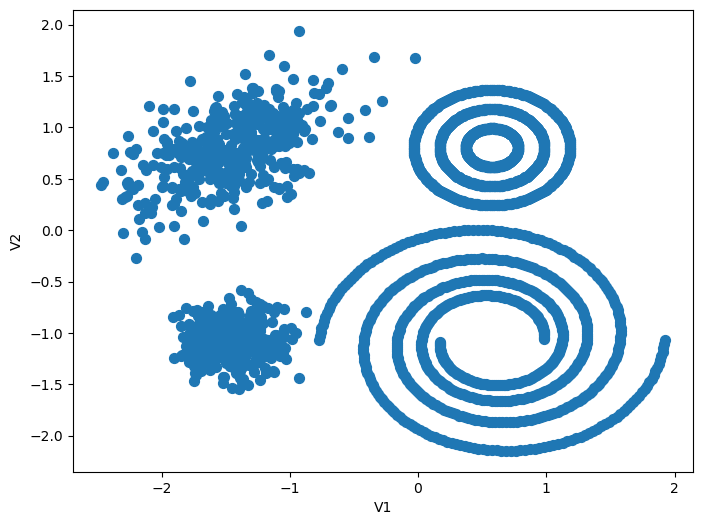

In [6]:
data_one = np.genfromtxt('donclassif.csv', delimiter=';')
data_one = np.delete(data_one, 0, 0)
data_one = StandardScaler().fit_transform(data_one)
plot_data(data_one[:, 0], data_one[:, 1])

### Find Number of Clusters using Silhouette Metric

Min Cluster Size: 5, Score: 0.17


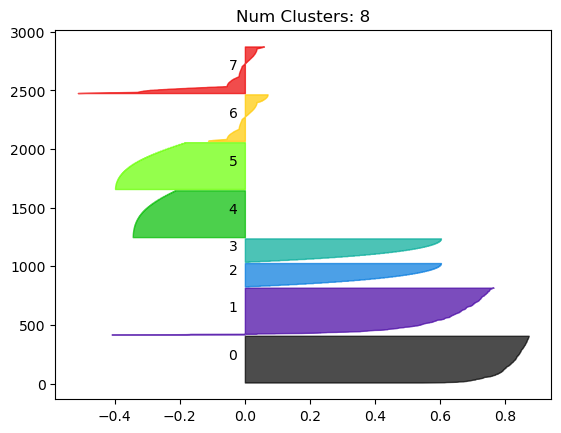

Min Cluster Size: 10, Score: 0.20


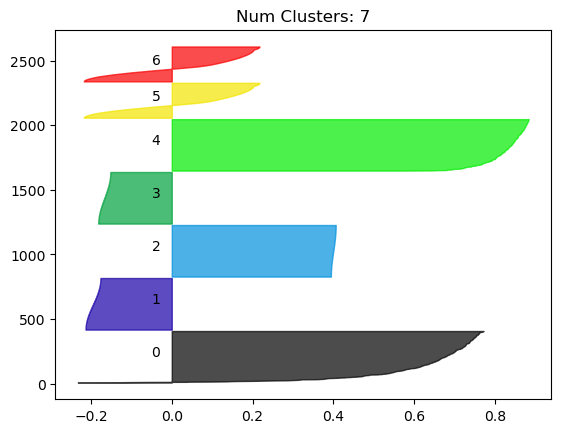

Min Cluster Size: 30, Score: 0.30


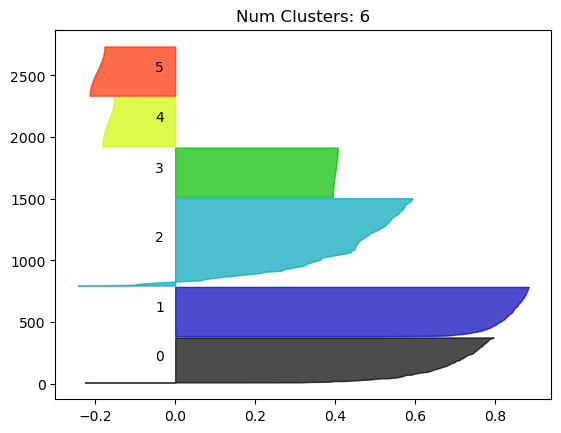

Min Cluster Size: 50, Score: 0.57


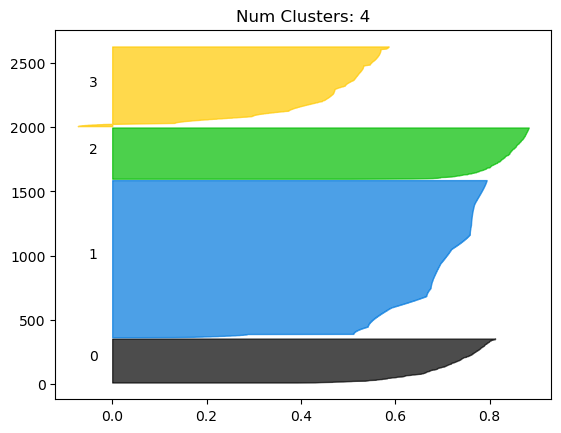

Min Cluster Size: 100, Score: 0.53


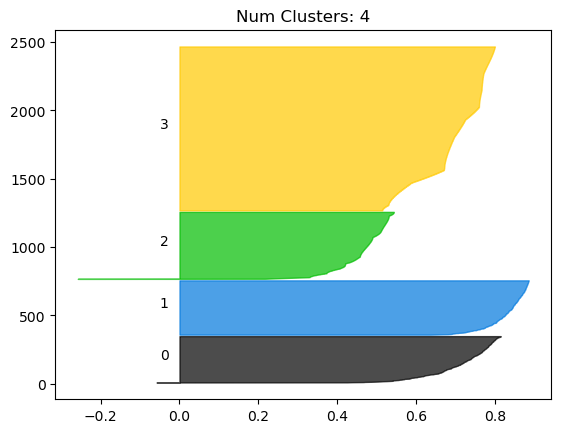

Min Cluster Size: 300, Score: 0.33


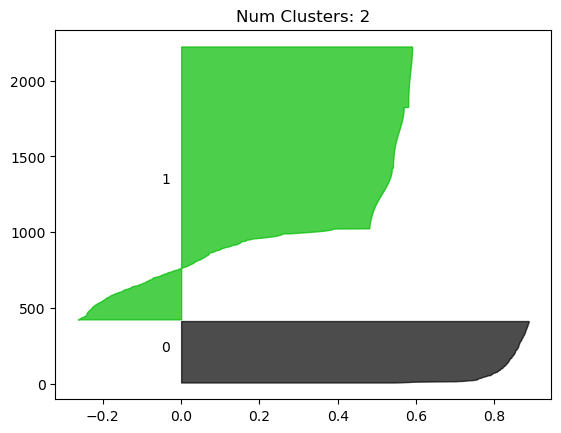

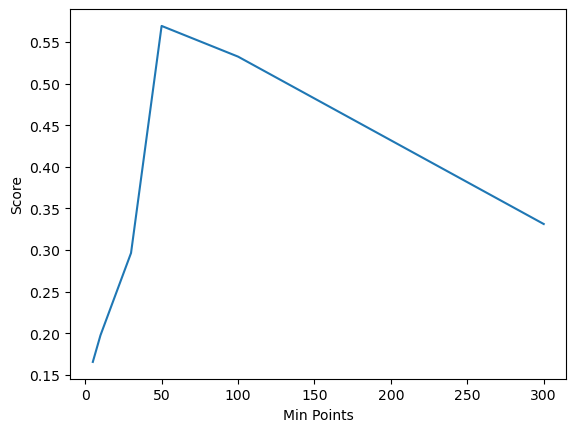

{'min_cluster_size': 50,
 'score': 0.5692642775582614,
 'labels': array([3, 3, 3, ..., 0, 0, 0])}

In [7]:
min_cluster_sizes = [5, 10, 30, 50, 100, 300]
hdbscan_best_params, hdbscan_history = evaluate_HDBSCAN_clustering(data_one,  min_cluster_sizes=min_cluster_sizes, metric='silhouette')
hdbscan_best_params

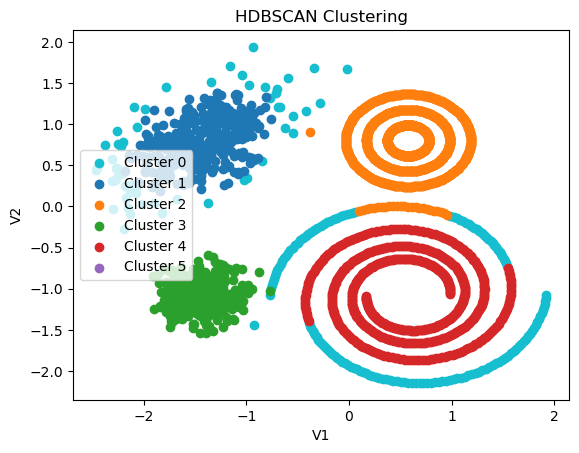

In [8]:
result_data_one = np.concatenate((data_one, hdbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_one, len(set(hdbscan_best_params['labels'])), 'HDBSCAN Clustering')

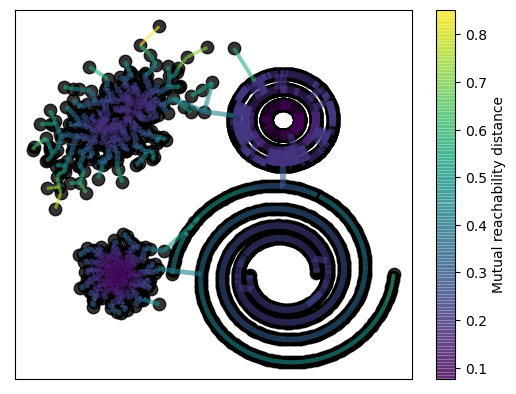

In [9]:
hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=hdbscan_best_params["min_cluster_size"], min_samples=None, p=None, prediction_data=False).fit(data_one)
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)

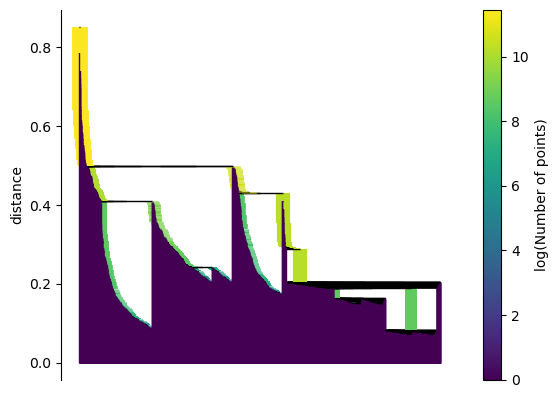

In [10]:
hdbscan.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Find Number of Clusters using Davies Bouldin Metric

Min Cluster Size: 5, Score: 5.74
Min Cluster Size: 10, Score: 18558521.03
Min Cluster Size: 30, Score: 21209733.72
Min Cluster Size: 50, Score: 1.98
Min Cluster Size: 100, Score: 2.19
Min Cluster Size: 300, Score: 1.77


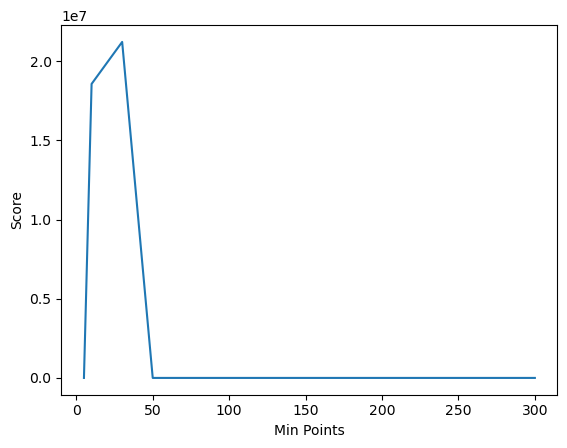

{'min_cluster_size': 300,
 'score': 1.7730845272196014,
 'labels': array([1, 1, 1, ..., 1, 1, 1])}

In [11]:
min_cluster_sizes = [5, 10, 30, 50, 100, 300]
hdbscan_best_params, hdbscan_history = evaluate_HDBSCAN_clustering(data_one,  min_cluster_sizes=min_cluster_sizes, metric='davies_bouldin')
hdbscan_best_params

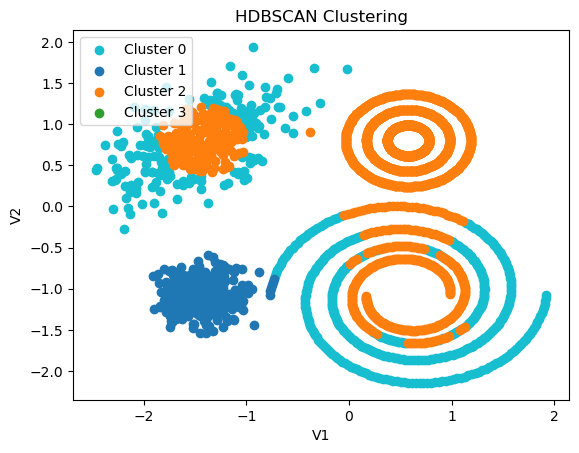

In [12]:
result_data_one = np.concatenate((data_one, hdbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_one, len(set(hdbscan_best_params['labels'])), 'HDBSCAN Clustering')

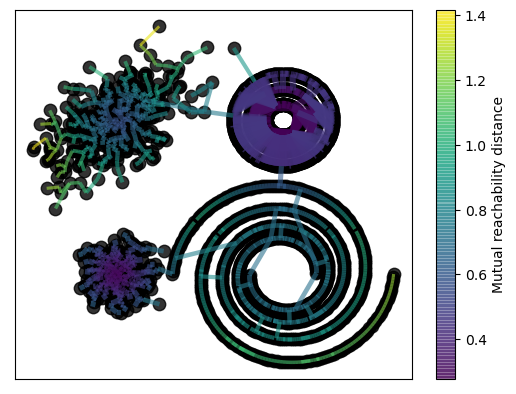

In [13]:

hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=hdbscan_best_params["min_cluster_size"], min_samples=None, p=None, prediction_data=False).fit(data_one)
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)

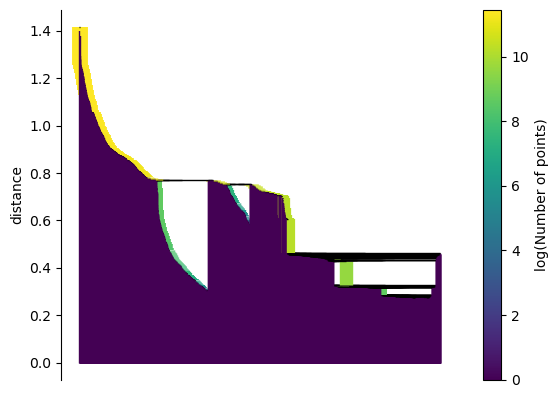

In [14]:
hdbscan.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

## Second Dataset

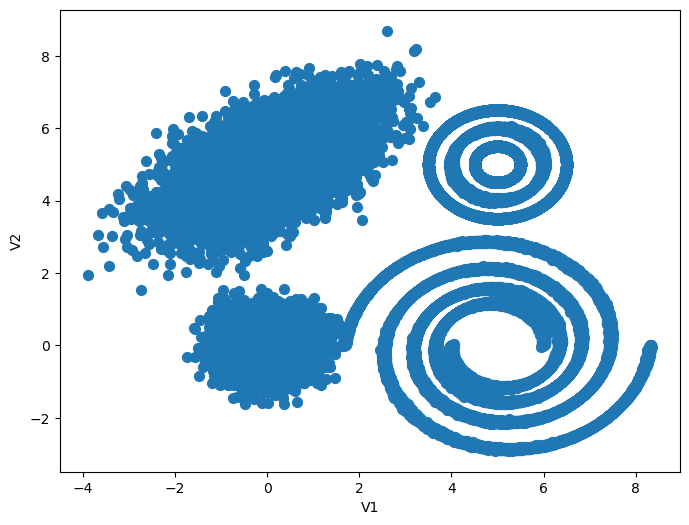

In [15]:
data_two = np.genfromtxt('donclassif2.csv', delimiter=';')
data_two = np.delete(data_two, 0, 0)
plot_data(data_two[:, 0], data_two[:, 1])

In [29]:
kmeans = KMeans(n_clusters=500, random_state=42).fit(data_two)
reduced_data_two = kmeans.cluster_centers_

### Find Number of Clusters using Silhouette Metric

Min Cluster Size: 5, Score: 0.41


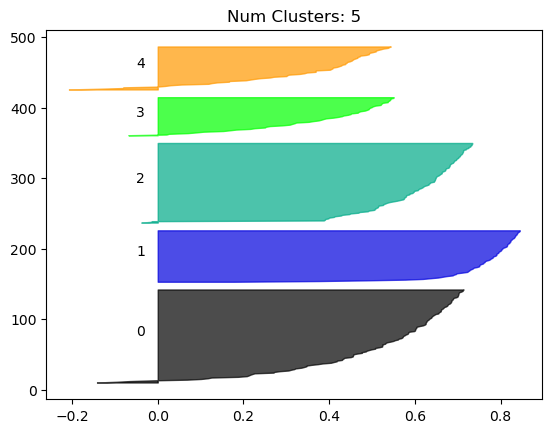

Min Cluster Size: 10, Score: 0.40


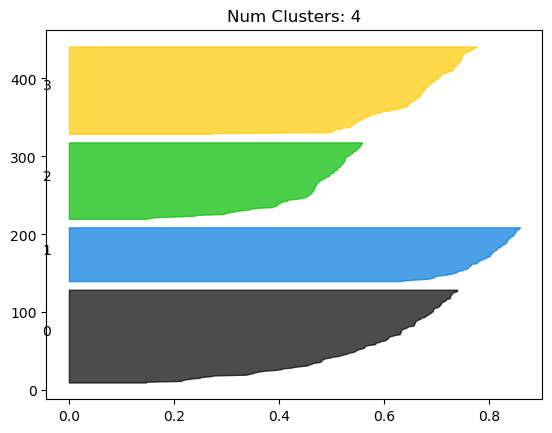

Min Cluster Size: 30, Score: 0.29


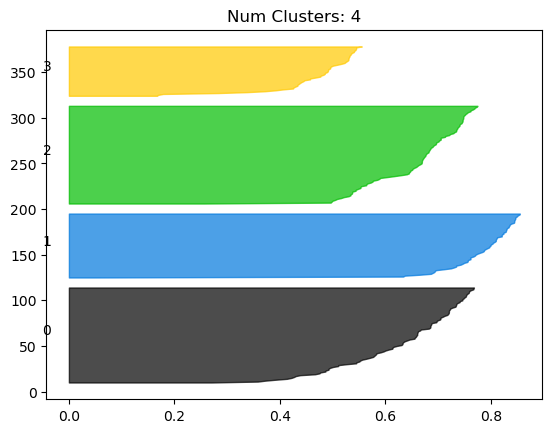

Min Cluster Size: 50, Score: 0.25


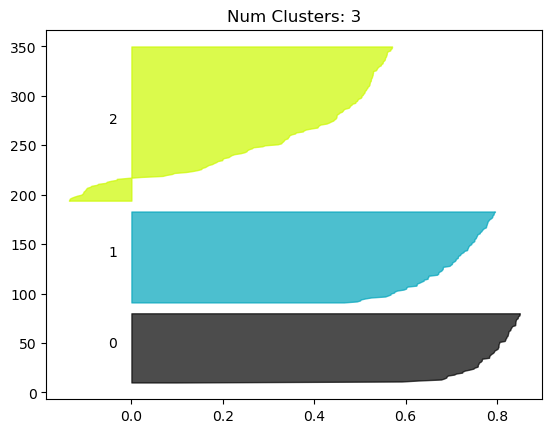

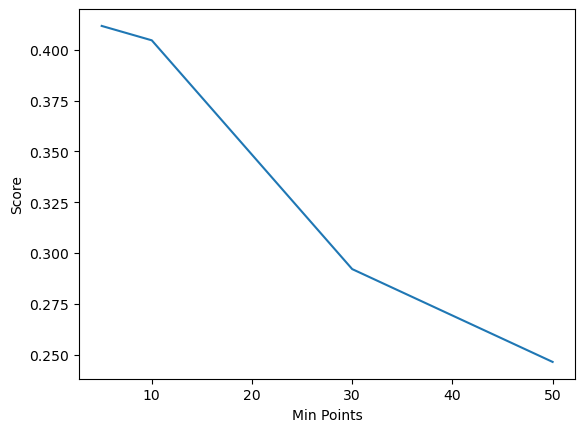

{'min_cluster_size': 5,
 'score': 0.41179827947191644,
 'labels': array([ 0,  2,  3,  1,  4,  0,  2,  0,  3,  4,  2,  2,  4,  3,  4,  2,  2,
         0, -1,  2,  1, -1,  2,  2,  4,  0,  4,  0,  2,  1,  0,  4,  4, -1,
         1,  2,  4,  2,  0,  2,  3, -1,  3,  4,  2,  2,  1,  2, -1,  3,  1,
         2,  2,  1,  0,  1, -1,  4,  3, -1,  0,  1,  3, -1, -1,  2,  0, -1,
         2,  0,  0, -1,  2, -1,  0,  2,  0,  0,  2,  1, -1,  3,  2,  4,  3,
         4,  0,  4, -1,  0,  4, -1,  3,  0,  2,  2,  2,  2,  2,  2,  0,  3,
         1,  3,  3,  0,  2,  4,  1,  0,  1,  3,  2,  3,  2,  2,  4,  2,  3,
        -1,  0,  4, -1,  0,  0,  4,  1,  3,  0,  2,  2,  0,  4,  2,  0,  4,
         2,  4,  0,  0,  4,  3,  1, -1,  4,  0,  0,  1, -1,  0,  0,  0,  1,
         2,  2,  4,  0,  4,  0,  4,  4,  2,  2,  1, -1,  1,  1,  3,  1,  1,
        -1,  3,  0,  3,  4,  0,  1,  2,  0,  0,  2,  2,  3,  1,  2, -1,  4,
         2, -1,  0, -1,  3,  3,  3,  2,  1,  2,  1,  1,  2,  0,  1,  4,  2,
         3,  2, -1,  1,

In [32]:
# min_cluster_sizes = [5, 10, 30, 50, 100, 300]
min_cluster_sizes = [5, 10, 30, 50]
hdbscan_best_params, hdbscan_history = evaluate_HDBSCAN_clustering(reduced_data_two,  min_cluster_sizes=min_cluster_sizes, metric='silhouette')
hdbscan_best_params

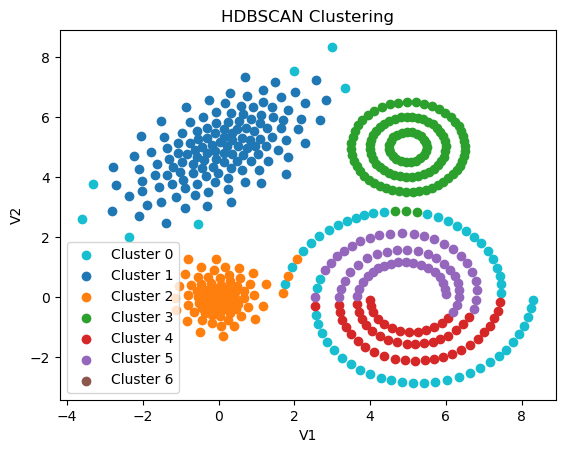

In [34]:
result_data_two = np.concatenate((reduced_data_two, hdbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_two, len(set(hdbscan_best_params['labels'])), 'HDBSCAN Clustering')

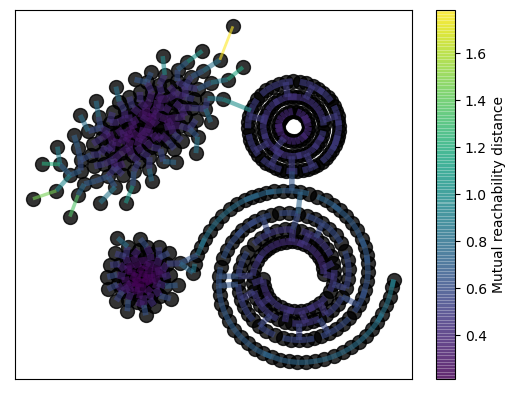

In [35]:
hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=hdbscan_best_params["min_cluster_size"], min_samples=None, p=None, prediction_data=False).fit(reduced_data_two)
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=100, edge_linewidth=2)

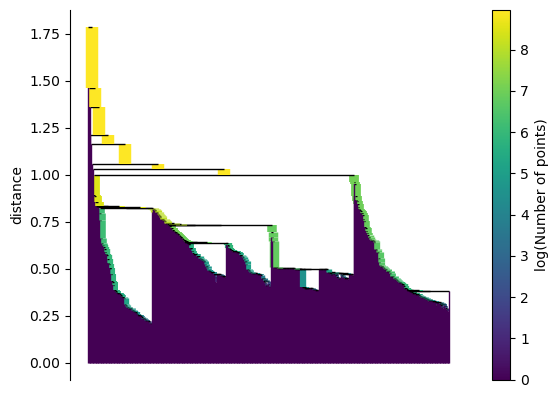

In [36]:
hdbscan.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Find Number of Clusters using Davies Bouldin Metric

Min Cluster Size: 5, Score: 0.41


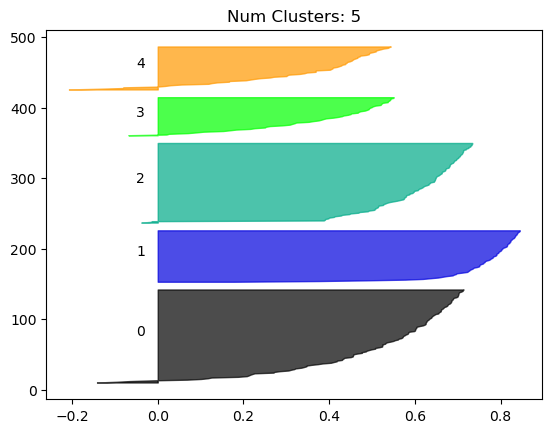

Min Cluster Size: 10, Score: 0.40


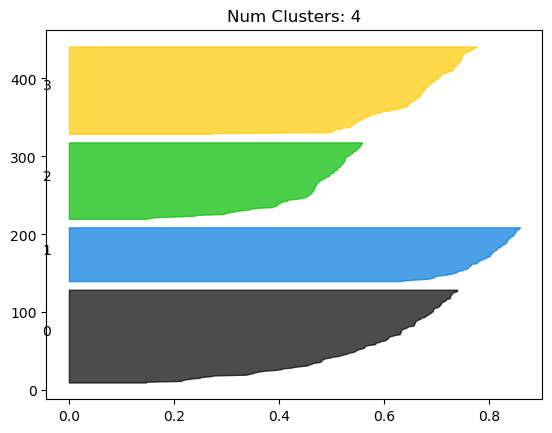

Min Cluster Size: 30, Score: 0.29


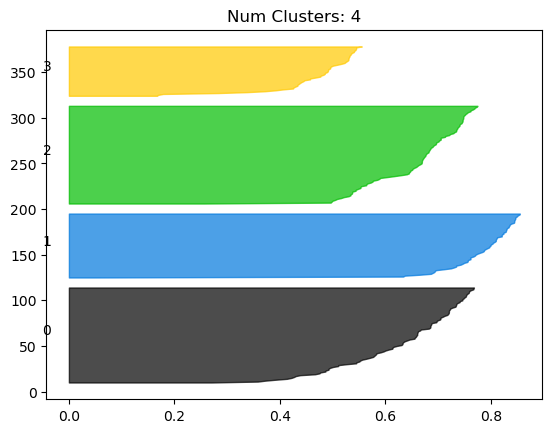

Min Cluster Size: 50, Score: 0.25


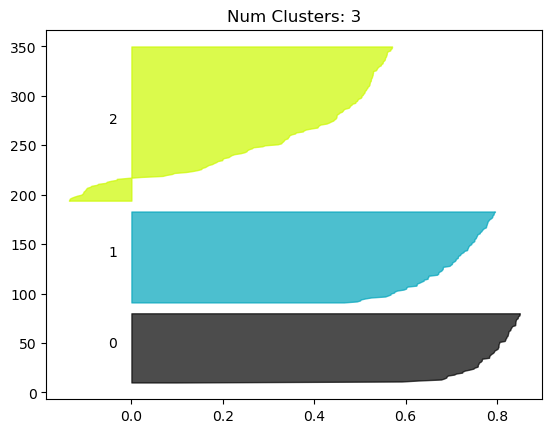

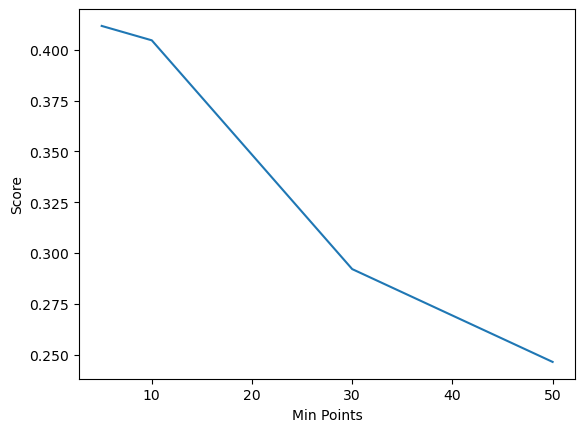

{'min_cluster_size': 5,
 'score': 0.41179827947191644,
 'labels': array([ 0,  2,  3,  1,  4,  0,  2,  0,  3,  4,  2,  2,  4,  3,  4,  2,  2,
         0, -1,  2,  1, -1,  2,  2,  4,  0,  4,  0,  2,  1,  0,  4,  4, -1,
         1,  2,  4,  2,  0,  2,  3, -1,  3,  4,  2,  2,  1,  2, -1,  3,  1,
         2,  2,  1,  0,  1, -1,  4,  3, -1,  0,  1,  3, -1, -1,  2,  0, -1,
         2,  0,  0, -1,  2, -1,  0,  2,  0,  0,  2,  1, -1,  3,  2,  4,  3,
         4,  0,  4, -1,  0,  4, -1,  3,  0,  2,  2,  2,  2,  2,  2,  0,  3,
         1,  3,  3,  0,  2,  4,  1,  0,  1,  3,  2,  3,  2,  2,  4,  2,  3,
        -1,  0,  4, -1,  0,  0,  4,  1,  3,  0,  2,  2,  0,  4,  2,  0,  4,
         2,  4,  0,  0,  4,  3,  1, -1,  4,  0,  0,  1, -1,  0,  0,  0,  1,
         2,  2,  4,  0,  4,  0,  4,  4,  2,  2,  1, -1,  1,  1,  3,  1,  1,
        -1,  3,  0,  3,  4,  0,  1,  2,  0,  0,  2,  2,  3,  1,  2, -1,  4,
         2, -1,  0, -1,  3,  3,  3,  2,  1,  2,  1,  1,  2,  0,  1,  4,  2,
         3,  2, -1,  1,

In [38]:
# min_cluster_sizes = [5, 10, 30, 50, 100, 300]
min_cluster_sizes = [5, 10, 30, 50]
hdbscan_best_params, hdbscan_history = evaluate_HDBSCAN_clustering(reduced_data_two,  min_cluster_sizes=min_cluster_sizes, metric='silhouette')
hdbscan_best_params

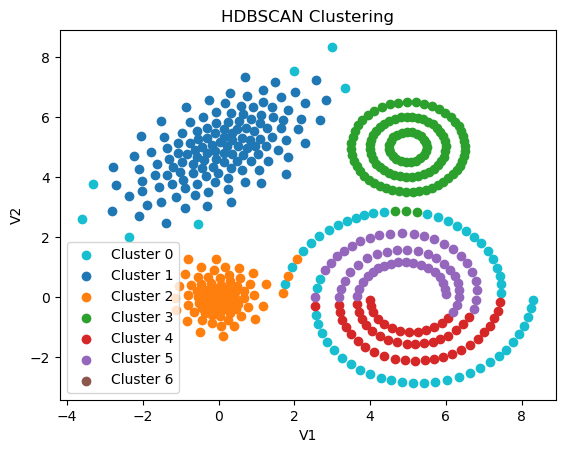

In [39]:
result_data_two = np.concatenate((reduced_data_two, hdbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_two, len(set(hdbscan_best_params['labels'])), 'HDBSCAN Clustering')

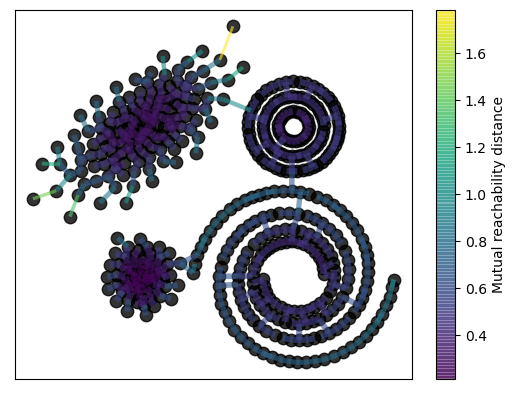

In [40]:
hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=hdbscan_best_params["min_cluster_size"], min_samples=None, p=None, prediction_data=False).fit(reduced_data_two)
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)

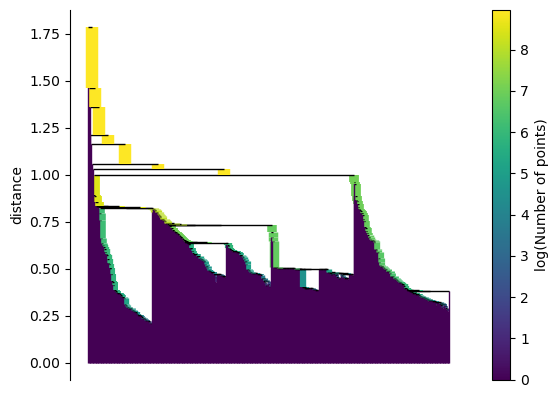

In [41]:
hdbscan.single_linkage_tree_.plot(cmap='viridis', colorbar=True)